# Extensive PyTorch Neural Network for F1 Lap Time Prediction
This notebook trains a tabular neural network with embeddings for categorical variables and produces extensive diagnostics, including **actual vs. predicted lap times over a single stint**.

Key constraints honored: no telemetry raw data; only lap aggregates; strict chronological split (2022 + first half 2023 vs. second half 2023); fixed random seeds.


In [1]:
from pathlib import Path
import sys

def find_project_root(start: Path) -> Path:
    for parent in [start] + list(start.parents):
        if (parent / "src").is_dir() and (parent / "requirements.txt").exists():
            return parent
    return start

project_root = find_project_root(Path.cwd().resolve())
sys.path.insert(0, str(project_root))
print('Project root:', project_root)


Project root: C:\Users\tvcar\Desktop\FOM\2. Semester\Maschinelles Lernen\ml_f1


In [2]:
# (Optional) autoreload for iterative work
%load_ext autoreload
%autoreload 2


## 1) Setup & Reproducibility


In [3]:
import os
import random
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from src.data_loader import enable_cache, load_laps_for_seasons, clean_laps
from src.features import build_feature_table
from src.evaluator import chronological_split, compute_metrics, compute_time_series_quality_metrics
from src.visualization import (
    setup_f1_style,
    plot_predictive_timing_tower,
    plot_tyre_error_correlation_heatmap,
    plot_race_evolution,
    model_reliability_score,
    stratified_mae_with_ci,
    plot_stratified_mae,
    plot_model_quality_scorecard,
    plot_calibration_curve,
    plot_uncertainty_vs_tyrelife,
    plot_coverage_by_uncertainty_bins,
)

from src.uncertainty import (
    mc_dropout_predict,
    nominal_vs_observed_coverage,
    calibration_coverage,
    coverage_by_uncertainty_bins,
)

setup_f1_style()
plt.rcParams["figure.figsize"] = (10, 6)

RANDOM_STATE = 42

def seed_everything(seed: int = 42) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(RANDOM_STATE)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE


device(type='cpu')

## 2) Load Data (cached) and Build Feature Table


In [4]:
DATA_DIR = Path("data")
CACHE_DIR = DATA_DIR / "cache"
PROCESSED_DIR = DATA_DIR / "processed"
FEATURES_PATH = PROCESSED_DIR / "feature_table.parquet"
FEATURES_CLEAN_PATH = PROCESSED_DIR / "feature_table_clean.parquet"

YEARS = [2022, 2023]  # keep the methodology clean by default

enable_cache(CACHE_DIR)


WindowsPath('data/cache')

In [5]:
def clean_data(laps: pd.DataFrame) -> pd.DataFrame:
    """Remove 'dirty' laps before training.

    Rules:
      1) Keep only green-flag laps where TrackStatus == '1'
      2) Remove laps slower than 107% of the median lap time for (EventName, Compound)
    """
    df = laps.copy()

    # 1) TrackStatus filter (FastF1 can store it as int/str; enforce exact '1')
    if "TrackStatus" in df.columns:
        status = df["TrackStatus"].astype(str)
        df = df[status == "1"].copy()

    # Need lap time in seconds for outlier filtering
    df = df[df["LapTime"].notna()].copy()
    df["LapTimeSeconds_tmp"] = df["LapTime"].dt.total_seconds()

    # 2) 107% rule per (EventName, Compound)
    if "Compound" not in df.columns:
        df["Compound"] = "UNKNOWN"
    if "EventName" not in df.columns:
        df["EventName"] = "UNKNOWN"

    df["Compound"] = df["Compound"].fillna("UNKNOWN").astype(str)
    df["EventName"] = df["EventName"].fillna("UNKNOWN").astype(str)

    med = df.groupby(["EventName", "Compound"], dropna=False)["LapTimeSeconds_tmp"].transform("median")
    df = df[df["LapTimeSeconds_tmp"] <= 1.07 * med].copy()

    df.drop(columns=["LapTimeSeconds_tmp"], inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df


def load_features_table(force_rebuild: bool = False) -> pd.DataFrame:
    # Prefer the cleaned feature table once created
    if FEATURES_CLEAN_PATH.exists() and not force_rebuild:
        return pd.read_parquet(FEATURES_CLEAN_PATH)

    raw_laps = load_laps_for_seasons(YEARS, cache_dir=CACHE_DIR)
    clean_laps_df = clean_laps(raw_laps)
    clean_laps_df = clean_data(clean_laps_df)

    feature_df, _, _ = build_feature_table(clean_laps_df)

    PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
    feature_df.to_parquet(FEATURES_CLEAN_PATH, index=False)
    return feature_df


feature_df = load_features_table(force_rebuild=False)
feature_df.head()


Race sessions:   0%|          | 0/44 [00:00<?, ?it/s]core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 16 completed the race distance 00:00.050000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '44', '63', '20', '77', '31', '22', '14', '24', '47', '18', '23', '3', '4', '6', '27', '11', '1', '10']
Race sessions:   2%|▏         | 1/44 [00:01<01:07,  1.57s/it]c

,LapNumber,Stint,TyreLife,LapTimeLag1,LapTimeLag2,LapTimeLag3,RollingMean3,Driver,Team,Compound,TrackStatusFlag,Circuit,LapTimeSeconds,Season,RoundNumber,EventName
0,2.0,1.0,2.0,NaN,NaN,NaN,NaN,ALB,Williams,SOFT,green,Sakhir,100.548,2022,1,Bahrain Grand Prix
1,3.0,1.0,3.0,100.548,NaN,NaN,100.548000,ALB,Williams,SOFT,green,Sakhir,100.664,2022,1,Bahrain Grand Prix
2,4.0,1.0,4.0,100.664,100.548,NaN,100.606000,ALB,Williams,SOFT,green,Sakhir,101.126,2022,1,Bahrain Grand Prix
3,5.0,1.0,5.0,101.126,100.664,100.548,100.779333,ALB,Williams,SOFT,green,Sakhir,102.303,2022,1,Bahrain Grand Prix
4,6.0,1.0,6.0,102.303,101.126,100.664,101.364333,ALB,Williams,SOFT,green,Sakhir,101.708,2022,1,Bahrain Grand Prix


In [6]:
# quick sanity checks
pd.Series({
    "rows": len(feature_df),
    "seasons": sorted(feature_df["Season"].dropna().unique().tolist()),
    "min_round": int(feature_df["RoundNumber"].min()),
    "max_round": int(feature_df["RoundNumber"].max()),
})


rows                38783
seasons      [2022, 2023]
min_round               1
max_round              22
dtype: object

## 3) Strict Chronological Split (No Leakage)


In [7]:
train_df, test_df = chronological_split(feature_df, split_season=2023)

pd.Series({
    "train_rows": len(train_df),
    "test_rows": len(test_df),
    "train_seasons": sorted(train_df["Season"].unique().tolist()),
    "test_seasons": sorted(test_df["Season"].unique().tolist()),
    "train_rounds_2023": sorted(train_df[train_df["Season"]==2023]["RoundNumber"].unique().tolist())[:5],
    "test_rounds_2023": sorted(test_df[test_df["Season"]==2023]["RoundNumber"].unique().tolist())[:5],
})


train_rows                          29321
test_rows                            9462
train_seasons                [2022, 2023]
test_seasons                       [2023]
train_rounds_2023         [1, 2, 3, 4, 5]
test_rounds_2023     [12, 13, 14, 15, 16]
dtype: object

## 4) Tabular Encoding (Embeddings for Categorical Features)


In [8]:
NUMERIC_COLS = [
    "LapNumber",
    "Stint",
    "TyreLife",
    "LapTimeLag1",
    "LapTimeLag2",
    "LapTimeLag3",
    "RollingMean3",
]

CATEGORICAL_COLS = [
    "Driver",
    "Team",
    "Compound",
    "TrackStatusFlag",
    "Circuit",
]

TARGET_COL = "LapTimeSeconds"

for col in NUMERIC_COLS + CATEGORICAL_COLS + [TARGET_COL]:
    if col not in feature_df.columns:
        raise KeyError(f"Missing required column: {col}")


In [9]:
@dataclass
class CategoryEncoder:
    mapping: dict[str, int]
    unknown_index: int

    def transform(self, series: pd.Series) -> np.ndarray:
        s = series.astype(str).fillna("<NA>")
        return np.array([self.mapping.get(v, self.unknown_index) for v in s], dtype=np.int64)


def fit_category_encoder(train_series: pd.Series, min_freq: int = 1) -> CategoryEncoder:
    s = train_series.astype(str).fillna("<NA>")
    counts = s.value_counts()
    kept = counts[counts >= min_freq].index.tolist()

    # reserve 0 for unknown
    mapping = {"<UNK>": 0}
    for i, v in enumerate(kept, start=1):
        mapping[v] = i
    return CategoryEncoder(mapping=mapping, unknown_index=0)


In [10]:
cat_encoders: dict[str, CategoryEncoder] = {
    col: fit_category_encoder(train_df[col], min_freq=2) for col in CATEGORICAL_COLS
}

{col: len(enc.mapping) for col, enc in cat_encoders.items()}


{'Driver': 25, 'Team': 11, 'Compound': 7, 'TrackStatusFlag': 2, 'Circuit': 23}

In [11]:
# Numeric imputation (train-only) to avoid NaNs from lag features
train_num_df = train_df[NUMERIC_COLS].astype(float)
test_num_df = test_df[NUMERIC_COLS].astype(float)

num_impute_values = train_num_df.median()
train_num_df = train_num_df.fillna(num_impute_values)
test_num_df = test_num_df.fillna(num_impute_values)

scaler = StandardScaler()
X_train_num = scaler.fit_transform(train_num_df)
X_test_num = scaler.transform(test_num_df)

X_train_cat = np.column_stack([cat_encoders[c].transform(train_df[c]) for c in CATEGORICAL_COLS])
X_test_cat = np.column_stack([cat_encoders[c].transform(test_df[c]) for c in CATEGORICAL_COLS])

y_train = train_df[TARGET_COL].astype(float).to_numpy()
y_test = test_df[TARGET_COL].astype(float).to_numpy()

# Sanity checks: model/training will break silently if NaNs slip through
for name, arr in {
    "X_train_num": X_train_num,
    "X_test_num": X_test_num,
    "y_train": y_train,
    "y_test": y_test,
}.items():
    if np.isnan(arr).any():
        raise ValueError(f"{name} contains NaNs. Check preprocessing/imputation.")

X_train_num.shape, X_train_cat.shape


((29321, 7), (29321, 5))

## 5) Dataset, Model, and Training Loop


In [12]:
class TabularDataset(Dataset):
    def __init__(self, X_num: np.ndarray, X_cat: np.ndarray, y: np.ndarray):
        self.X_num = torch.tensor(X_num, dtype=torch.float32)
        self.X_cat = torch.tensor(X_cat, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self) -> int:
        return len(self.y)

    def __getitem__(self, idx: int):
        return self.X_num[idx], self.X_cat[idx], self.y[idx]


def make_train_val_split(df: pd.DataFrame, val_fraction: float = 0.1) -> tuple[np.ndarray, np.ndarray]:
    # time-respecting split within training set (use original indices)
    order = df.sort_values(["Season", "RoundNumber", "LapNumber"]).index.to_numpy()
    n = len(order)
    n_val = max(1, int(n * val_fraction))
    train_idx = order[:-n_val]
    val_idx = order[-n_val:]
    return train_idx, val_idx

train_idx, val_idx = make_train_val_split(train_df, val_fraction=0.1)

train_dataset = TabularDataset(X_train_num[train_idx], X_train_cat[train_idx], y_train[train_idx])
val_dataset = TabularDataset(X_train_num[val_idx], X_train_cat[val_idx], y_train[val_idx])
test_dataset = TabularDataset(X_test_num, X_test_cat, y_test)

BATCH_SIZE = 512
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

len(train_dataset), len(val_dataset), len(test_dataset)


(26389, 2932, 9462)

In [13]:
def embedding_dim(n_categories: int) -> int:
    return min(64, max(4, int(round(n_categories ** 0.5))))


def embedding_dim_for_feature(name: str, n_categories: int) -> int:
    base = embedding_dim(n_categories)
    name_l = str(name).lower()
    if name_l == "driver":
        return max(16, base)
    if name_l == "compound":
        return max(8, base)
    return base


class TabularMLP(nn.Module):
    """MLP with categorical embeddings + BatchNorm + Dropout."""

    def __init__(
        self,
        n_numeric: int,
        cat_names: list[str],
        cat_cardinalities: list[int],
        hidden_sizes: tuple[int, ...] = (256, 128, 64),
        dropout: float = 0.1,
    ):
        super().__init__()

        if len(cat_names) != len(cat_cardinalities):
            raise ValueError("cat_names and cat_cardinalities must have the same length")

        self.embeddings = nn.ModuleList(
            [
                nn.Embedding(int(card), embedding_dim_for_feature(name, int(card)))
                for name, card in zip(cat_names, cat_cardinalities)
            ]
        )
        emb_out_dim = int(sum(e.embedding_dim for e in self.embeddings))

        in_dim = int(n_numeric + emb_out_dim)
        layers: list[nn.Module] = []
        for h in hidden_sizes:
            h = int(h)
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(float(dropout)))
            in_dim = h
        layers.append(nn.Linear(in_dim, 1))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x_num: torch.Tensor, x_cat: torch.Tensor) -> torch.Tensor:
        embedded = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat([x_num] + embedded, dim=1)
        out = self.mlp(x)
        return out.squeeze(1)


In [14]:
cat_cardinalities = [len(cat_encoders[c].mapping) for c in CATEGORICAL_COLS]

model = TabularMLP(
    n_numeric=len(NUMERIC_COLS),
    cat_names=CATEGORICAL_COLS,
    cat_cardinalities=cat_cardinalities,
    hidden_sizes=(256, 128, 64),
    dropout=0.1,
).to(DEVICE)

sum(p.numel() for p in model.parameters())


54256

In [15]:
def evaluate_loader(model: nn.Module, loader: DataLoader) -> tuple[float, float]:
    model.eval()
    preds = []
    ys = []
    with torch.no_grad():
        for x_num, x_cat, y in loader:
            x_num = x_num.to(DEVICE)
            x_cat = x_cat.to(DEVICE)
            y = y.to(DEVICE)
            pred = model(x_num, x_cat)
            preds.append(pred.detach().cpu().numpy())
            ys.append(y.detach().cpu().numpy())
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(preds)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    return mae, rmse


EPOCHS = 60
LR = 1e-3
WEIGHT_DECAY = 1e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
loss_fn = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)

best_val_mae = float("inf")
best_state = None
patience = 8
patience_left = patience

history = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_losses = []

    for x_num, x_cat, y in train_loader:
        x_num = x_num.to(DEVICE)
        x_cat = x_cat.to(DEVICE)
        y = y.to(DEVICE)

        optimizer.zero_grad()
        pred = model(x_num, x_cat)
        loss = loss_fn(pred, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = float(np.mean(train_losses))
    val_mae, val_rmse = evaluate_loader(model, val_loader)
    scheduler.step(val_mae)

    history.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_mae": val_mae,
        "val_rmse": val_rmse,
        "lr": optimizer.param_groups[0]["lr"],
    })

    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        patience_left = patience
    else:
        patience_left -= 1

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | train_loss={train_loss:.4f} | val_mae={val_mae:.3f} | lr={optimizer.param_groups[0]['lr']:.2e}")

    if patience_left <= 0:
        print(f"Early stopping at epoch {epoch} (best val_mae={best_val_mae:.3f})")
        break

# restore best model
if best_state is not None:
    model.load_state_dict(best_state)


TypeError: got an unexpected keyword argument 'squared'

In [ ]:
history_df = pd.DataFrame(history)
history_df.tail()

,epoch,train_loss,val_mae,val_rmse,lr
32,33,59.516598,1.255999,1.969339,0.00050
33,34,57.810282,0.828531,1.579528,0.00050
34,35,58.620084,0.952567,1.730999,0.00050
35,36,56.365296,0.807572,1.596604,0.00050
36,37,56.254993,0.988399,1.853513,0.00025


## 6) Test Evaluation (MAE/RMSE/R?)


In [ ]:
def predict_loader(model: nn.Module, loader: DataLoader) -> np.ndarray:
    model.eval()
    preds = []
    with torch.no_grad():
        for x_num, x_cat, _y in loader:
            x_num = x_num.to(DEVICE)
            x_cat = x_cat.to(DEVICE)
            pred = model(x_num, x_cat)
            preds.append(pred.detach().cpu().numpy())
    return np.concatenate(preds)


y_pred_test = predict_loader(model, test_loader)

test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
test_r2 = r2_score(y_test, y_pred_test)

pd.Series({"MAE": test_mae, "RMSE": test_rmse, "R2": test_r2})


MAE     2.436966
RMSE    4.219614
R2      0.847539
dtype: float64

In [ ]:
# Clean MAE: focus on competitive racing laps
CLEAN_LAPTIME_THRESHOLD_S = 95.0
clean_mask = y_test < CLEAN_LAPTIME_THRESHOLD_S

if int(clean_mask.sum()) == 0:
    raise ValueError('No laps under the clean threshold; adjust CLEAN_LAPTIME_THRESHOLD_S.')

clean_mae = mean_absolute_error(y_test[clean_mask], y_pred_test[clean_mask])
clean_rmse = mean_squared_error(y_test[clean_mask], y_pred_test[clean_mask], squared=False)

pd.Series({
    'Clean_MAE': float(clean_mae),
    'Clean_RMSE': float(clean_rmse),
    'Clean_n': int(clean_mask.sum()),
    'All_n': int(len(y_test)),
})


In [ ]:
# Naive baseline: use rolling mean of last 3 laps (fallback to lags)
baseline_pred = test_df["RollingMean3"].copy()
baseline_pred = baseline_pred.fillna(test_df["LapTimeLag1"])                             .fillna(test_df["LapTimeLag2"])                             .fillna(test_df["LapTimeLag3"])                             .fillna(train_df["LapTimeSeconds"].median())

baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = mean_squared_error(y_test, baseline_pred, squared=False)
baseline_r2 = r2_score(y_test, baseline_pred)

pd.DataFrame([
    {"model": "naive_rolling3", "MAE": baseline_mae, "RMSE": baseline_rmse, "R2": baseline_r2},
    {"model": "pytorch_mlp", "MAE": test_mae, "RMSE": test_rmse, "R2": test_r2},
]).set_index("model").sort_values("MAE")


,MAE,RMSE,R2
model,,,
naive_rolling3,1.073982,3.673352,0.884459
pytorch_mlp,2.436966,4.219614,0.847539


## 6b) F1-Style Dashboard Visualizations


In [ ]:
# Model reliability score (0-100%) based on variance of errors
reliability = model_reliability_score(y_test, y_pred_test)
print(f"Model Reliability Score: {reliability:.1f}%")


Model Reliability Score: 5.4%


,Driver,Team,MAE
0,RIC,AlphaTauri,1.495214
1,SAI,Ferrari,1.900035
2,LEC,Ferrari,2.105141
3,HAM,Mercedes,2.186311
4,BOT,Alfa Romeo,2.278226
5,NOR,McLaren,2.287126
6,TSU,AlphaTauri,2.339616
7,ZHO,Alfa Romeo,2.356857
8,HUL,Haas F1 Team,2.382585
9,MAG,Haas F1 Team,2.447466


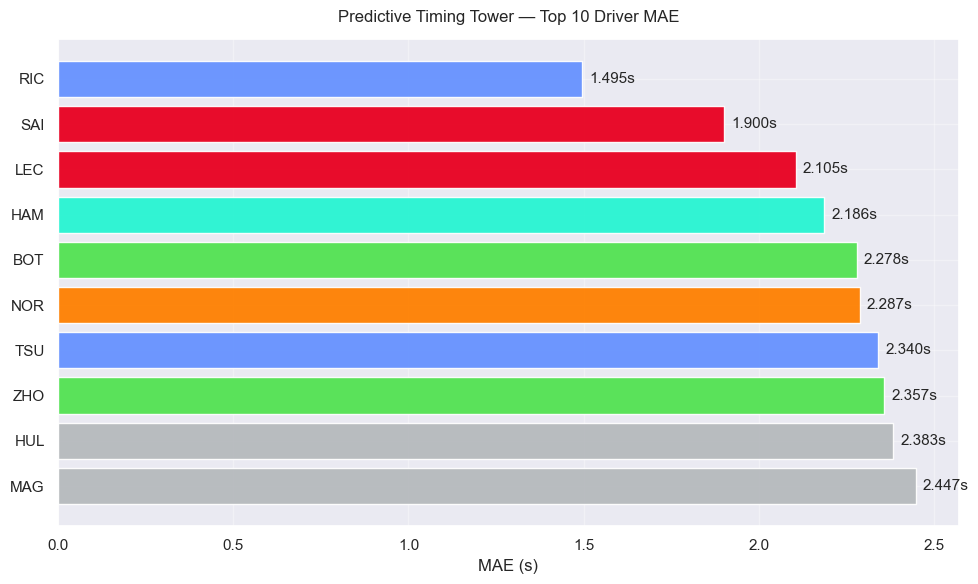

In [ ]:
# Predictive Timing Tower: Top 10 drivers by MAE (colored by team)
res = plot_predictive_timing_tower(test_df, y_test, y_pred_test, top_n=10)
res.table


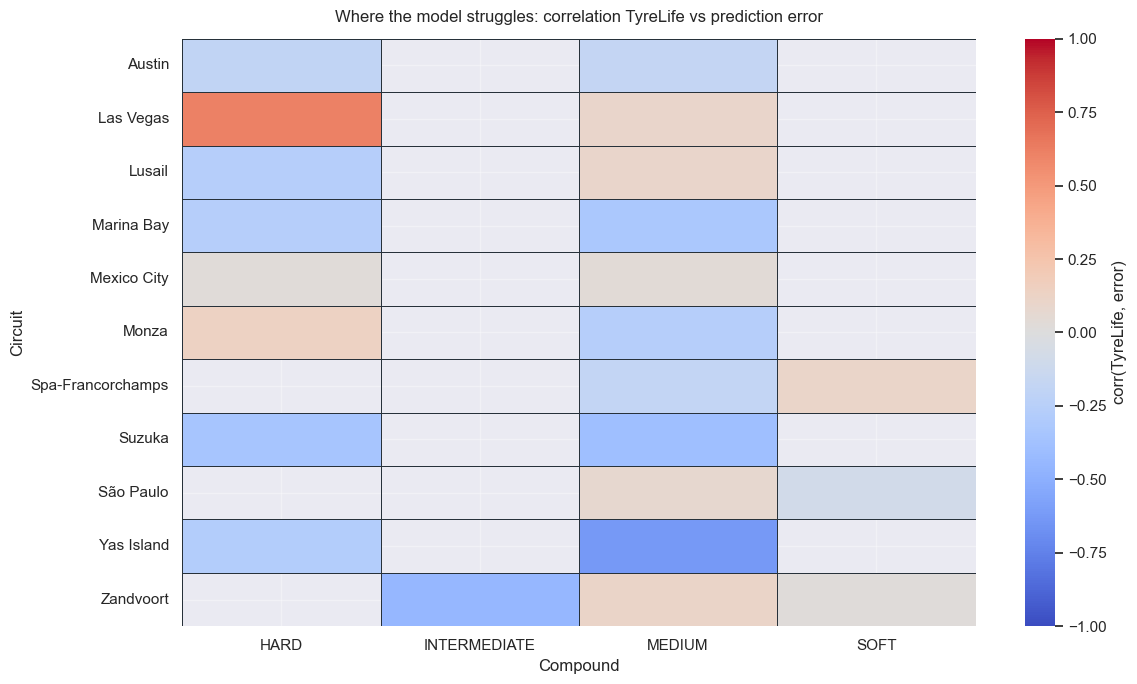

In [ ]:
# Heatmap: corr(TyreLife, prediction error) by Circuit x Compound
heat_df = test_df.copy().reset_index(drop=True)
heat_df["pred"] = y_pred_test
plot_tyre_error_correlation_heatmap(heat_df, row="Circuit", col="Compound")
plt.show()


## 6c) Time-Series Quality Metrics


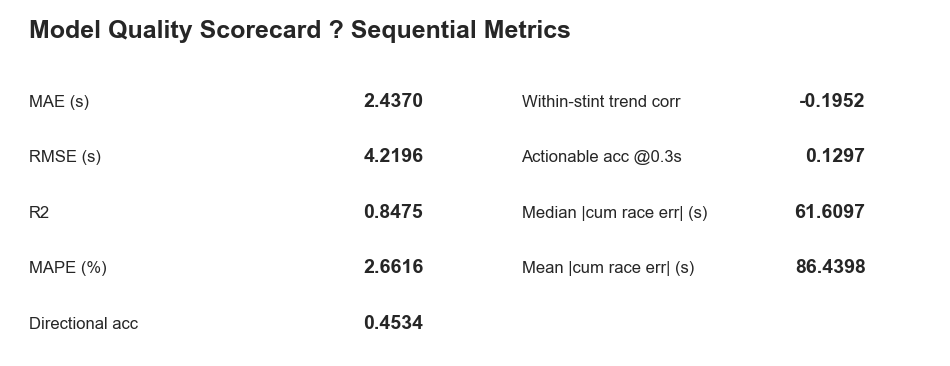

,Season,RoundNumber,Driver,cum_error_s,abs_cum_error_s
0,2023,17,VER,406.514423,406.514423
1,2023,17,ALB,403.034236,403.034236
2,2023,17,LAW,367.535951,367.535951
3,2023,17,PER,367.063497,367.063497
4,2023,17,MAG,351.226180,351.226180
5,2023,17,HUL,350.893613,350.893613
6,2023,17,ZHO,350.881977,350.881977
7,2023,17,GAS,343.922725,343.922725
8,2023,17,OCO,327.822072,327.822072
9,2023,17,NOR,316.427352,316.427352


In [ ]:
# Attach point predictions and compute sequential metrics
seq_df = test_df.copy().reset_index(drop=True)
seq_df["pred"] = y_pred_test

basic_metrics = compute_metrics(y_test, y_pred_test)
ts_metrics, per_stint_corr, per_race_cum = compute_time_series_quality_metrics(
    seq_df,
    actual_col="LapTimeSeconds",
    pred_col="pred",
    threshold_s=0.3,
)

# Combine into one scorecard
scorecard = {
    "MAE (s)": basic_metrics["mae"],
    "RMSE (s)": basic_metrics["rmse"],
    "R2": basic_metrics["r2"],
    "MAPE (%)": ts_metrics["mape_pct"],
    "Directional acc": ts_metrics["directional_accuracy"],
    "Within-stint trend corr": ts_metrics["within_stint_trend_corr"],
    "Actionable acc @0.3s": ts_metrics["actionable_accuracy@0.3s"],
    "Median |cum race err| (s)": ts_metrics["cumulative_race_time_abs_error_s_median"],
    "Mean |cum race err| (s)": ts_metrics["cumulative_race_time_abs_error_s_mean"],
}

plot_model_quality_scorecard(scorecard, title="Model Quality Scorecard ? Sequential Metrics")
plt.show()

# Optional: inspect worst cumulative race-time errors
per_race_cum.head(10)


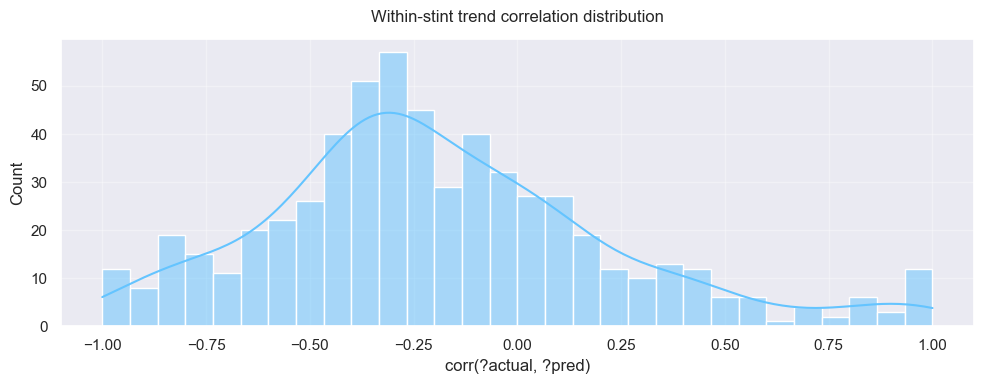

In [ ]:
# Distribution of within-stint trend correlations
if not per_stint_corr.empty:
    plt.figure(figsize=(10, 4))
    sns.histplot(per_stint_corr["corr"].dropna(), bins=30, kde=True, color="#64C4FF")
    plt.title("Within-stint trend correlation distribution")
    plt.xlabel("corr(?actual, ?pred)")
    plt.tight_layout()
    plt.show()


## 6d) Prediction Uncertainty (MC Dropout)


In [ ]:
# MC Dropout inference (30 stochastic forward passes)
# Note: this can take ~1-3 minutes on CPU depending on your machine.
MC_SAMPLES = 30
mc = mc_dropout_predict(model, test_loader, n_samples=MC_SAMPLES, device=DEVICE, seed=RANDOM_STATE)

ci_low_90, ci_high_90 = mc.interval(level=0.90)
coverage_90 = calibration_coverage(y_test, ci_low_90, ci_high_90)
print(f"90% CI empirical coverage: {coverage_90:.3f}")

unc_df = test_df.copy().reset_index(drop=True)
unc_df["pred"] = mc.mean
unc_df["pred_std"] = mc.std
unc_df["ci_low_90"] = ci_low_90
unc_df["ci_high_90"] = ci_high_90

unc_df[["pred", "pred_std", "ci_low_90", "ci_high_90"]].head()


90% CI empirical coverage: 0.979


,pred,pred_std,ci_low_90,ci_high_90
0,108.932991,9.458978,92.056420,119.931997
1,111.531975,8.234477,97.809012,122.770696
2,110.641380,9.082104,95.604799,124.240268
3,111.528511,9.435068,99.000191,127.477785
4,112.835304,7.808357,99.745670,122.976287


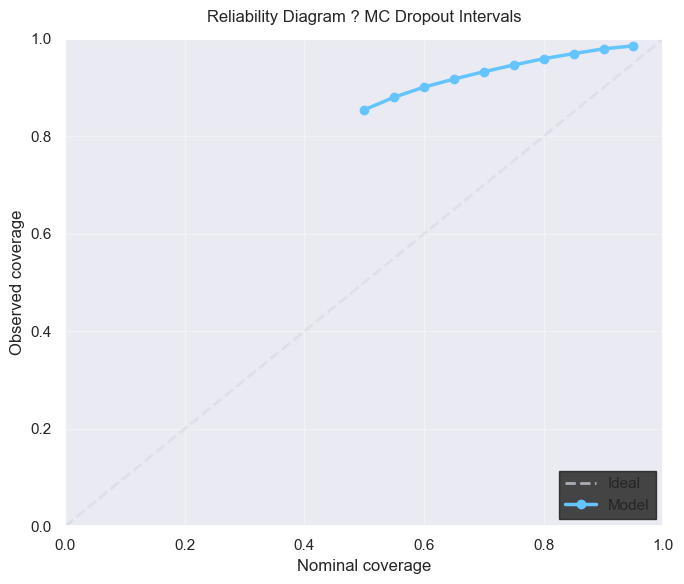

In [ ]:
# Reliability diagram: nominal vs observed coverage
levels = np.linspace(0.50, 0.95, 10).tolist()
nom_obs = nominal_vs_observed_coverage(mc.samples, y_test, levels=levels)
plot_calibration_curve(nom_obs, title="Reliability Diagram ? MC Dropout Intervals")
plt.show()


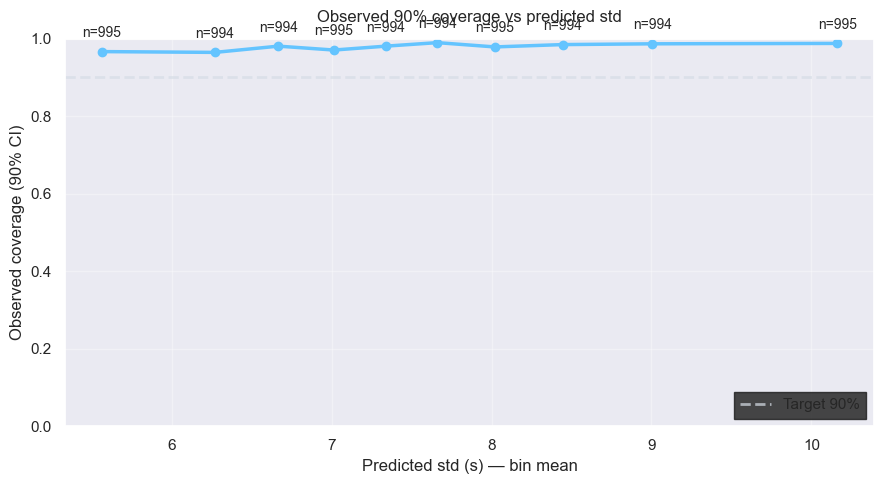

In [ ]:
# Calibration by predicted uncertainty (std bins)
binned = coverage_by_uncertainty_bins(y_test, ci_low_90, ci_high_90, mc.std, n_bins=10)
plot_coverage_by_uncertainty_bins(binned, title="Observed 90% coverage vs predicted std")
plt.show()


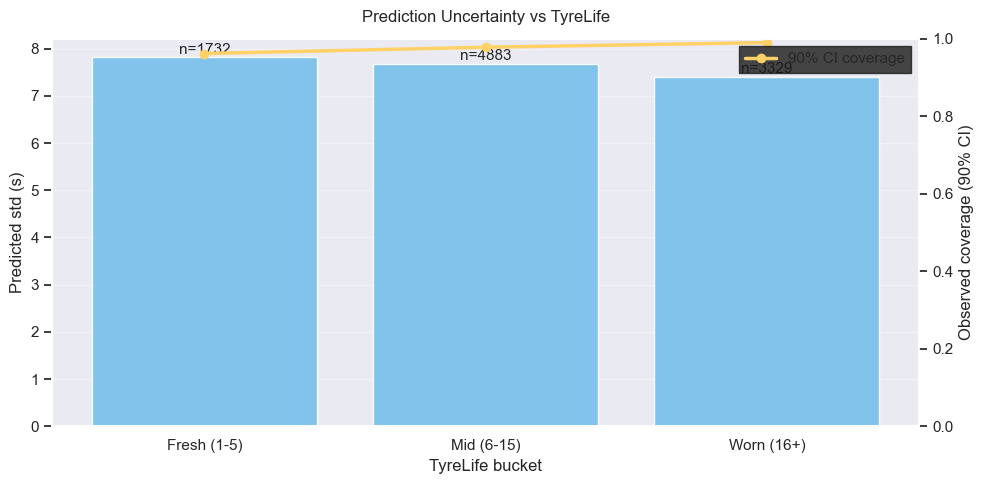

In [ ]:
# Coverage plot: uncertainty and 90% coverage vs TyreLife bucket
plot_uncertainty_vs_tyrelife(
    unc_df,
    tyre_life_col="TyreLife",
    std_col="pred_std",
    actual_col="LapTimeSeconds",
    lower_col="ci_low_90",
    upper_col="ci_high_90",
)
plt.show()


## Stratified Error Analysis (with 95% CI)
Break down model MAE by key race factors. CIs are bootstrap CIs on the mean absolute error (MAE).


In [ ]:
# Build an analysis table (test split only)
analysis_df = test_df.copy().reset_index(drop=True)
analysis_df["pred"] = y_pred_test
analysis_df["actual"] = y_test
analysis_df["error"] = analysis_df["pred"] - analysis_df["actual"]
analysis_df["abs_err"] = analysis_df["error"].abs()

# 1) Tyre compound
analysis_df["compound"] = analysis_df["Compound"].astype(str)

# 2) Stint number buckets
analysis_df["stint_bucket"] = np.where(analysis_df["Stint"].astype(float) <= 1, "Stint 1", np.where(analysis_df["Stint"].astype(float) == 2, "Stint 2", "Stint 3+"))

# 3) Track status buckets
# Note: SC/VSC laps were filtered out in preprocessing; remaining are typically green/yellow.
status = analysis_df.get("TrackStatusFlag", pd.Series(["unknown"] * len(analysis_df)))
status = status.astype(str).str.lower()
analysis_df["track_bucket"] = np.where(status == "green", "Green", np.where(status == "yellow", "Yellow/VSC/SC", "Yellow/VSC/SC"))

# 4) Circuit type (heuristic; edit `STREET_TOKENS` to taste)
STREET_TOKENS = [
    "monaco", "monte", "singapore", "baku", "jeddah", "las vegas", "miami", "melbourne",
]

circuit = analysis_df["Circuit"].astype(str).str.lower()
analysis_df["circuit_type"] = np.where(
    circuit.apply(lambda s: any(tok in s for tok in STREET_TOKENS)),
    "Street",
    "Permanent",
)

# 5) Driver experience tier (by team; edit as needed)
TOP_TEAMS = ["Red Bull", "Ferrari", "Mercedes", "McLaren", "Aston Martin"]
MIDFIELD = ["Alpine", "Williams", "RB", "Racing Bulls", "AlphaTauri", "Sauber", "Kick Sauber", "Alfa Romeo"]
BACKMARKERS = ["Haas"]

def team_tier(team: str) -> str:
    t = str(team)
    if any(x.lower() in t.lower() for x in TOP_TEAMS):
        return "Top teams"
    if any(x.lower() in t.lower() for x in MIDFIELD):
        return "Midfield"
    if any(x.lower() in t.lower() for x in BACKMARKERS):
        return "Backmarkers"
    return "Other"

analysis_df["experience_tier"] = analysis_df["Team"].astype(str).apply(team_tier)

# 6) TyreLife buckets
ty = analysis_df["TyreLife"].astype(float)
analysis_df["tyrelife_bucket"] = pd.cut(
    ty,
    bins=[-np.inf, 5, 15, np.inf],
    labels=["Fresh (1-5)", "Mid (6-15)", "Worn (16+)"]
).astype(str)

analysis_df[["abs_err", "compound", "stint_bucket", "track_bucket", "circuit_type", "experience_tier", "tyrelife_bucket"]].head()


,abs_err,compound,stint_bucket,track_bucket,circuit_type,experience_tier,tyrelife_bucket
0,7.120103,SOFT,Stint 1,Yellow/VSC/SC,Permanent,Midfield,Fresh (1-5)
1,1.838168,SOFT,Stint 1,Yellow/VSC/SC,Permanent,Midfield,Fresh (1-5)
2,2.533510,SOFT,Stint 1,Green,Permanent,Midfield,Fresh (1-5)
3,3.549919,SOFT,Stint 1,Green,Permanent,Midfield,Fresh (1-5)
4,1.721575,SOFT,Stint 1,Green,Permanent,Midfield,Mid (6-15)


,group,n,mae,ci_low,ci_high
0,HARD,4090,2.203342,2.111621,2.294064
1,MEDIUM,3901,2.215361,2.113912,2.335210
2,SOFT,1744,2.968993,2.818050,3.156893
3,INTERMEDIATE,209,6.705647,6.202903,7.344558


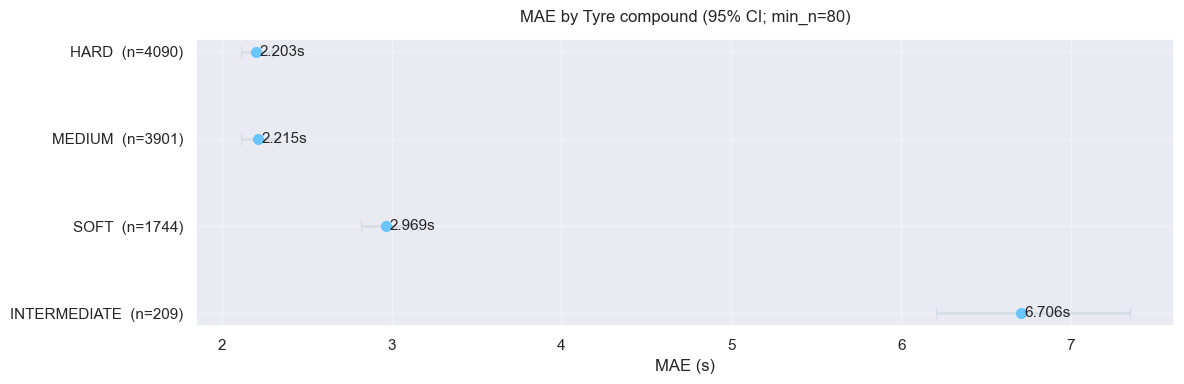

,group,n,mae,ci_low,ci_high
0,Stint 1,2250,2.064440,1.948607,2.196739
1,Stint 2,3194,2.288655,2.197385,2.397892
2,Stint 3+,4500,2.728498,2.624821,2.843273


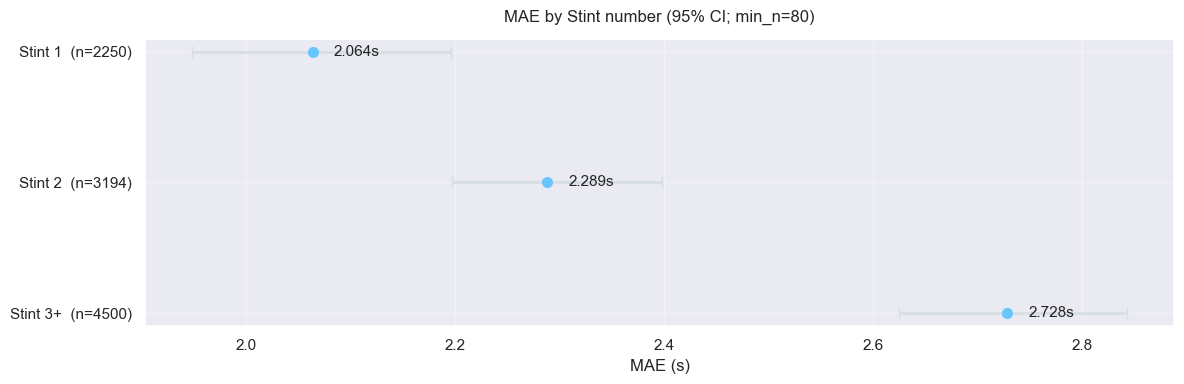

,group,n,mae,ci_low,ci_high
0,Green,9540,2.354735,2.292665,2.426101
1,Yellow/VSC/SC,404,4.378772,4.004247,4.763646


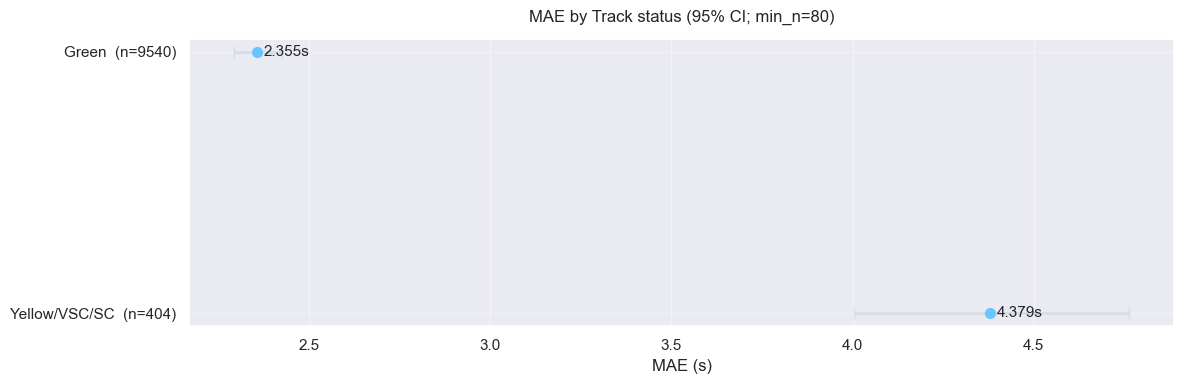

,group,n,mae,ci_low,ci_high
0,Permanent,9206,2.280768,2.217853,2.354983
1,Street,738,4.385421,4.151729,4.611566


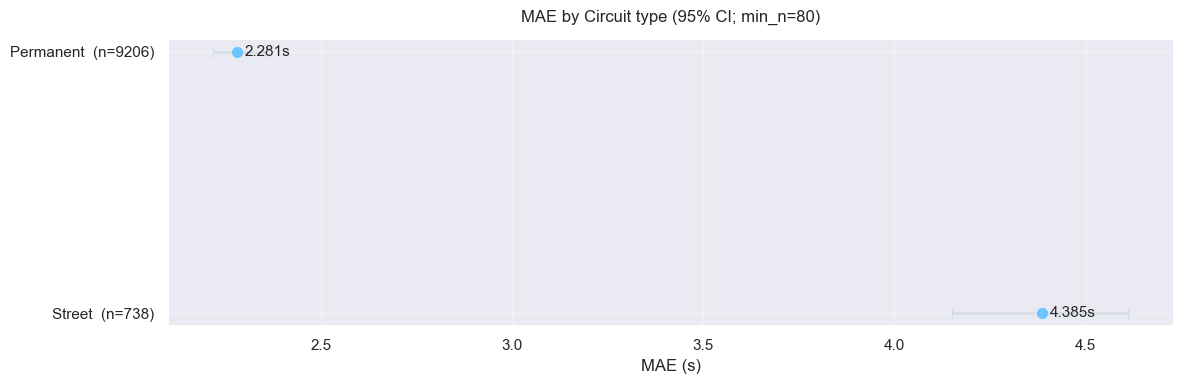

,group,n,mae,ci_low,ci_high
0,Backmarkers,999,2.411940,2.219005,2.607671
1,Top teams,5006,2.414334,2.318510,2.510914
2,Midfield,3939,2.472077,2.371256,2.582334


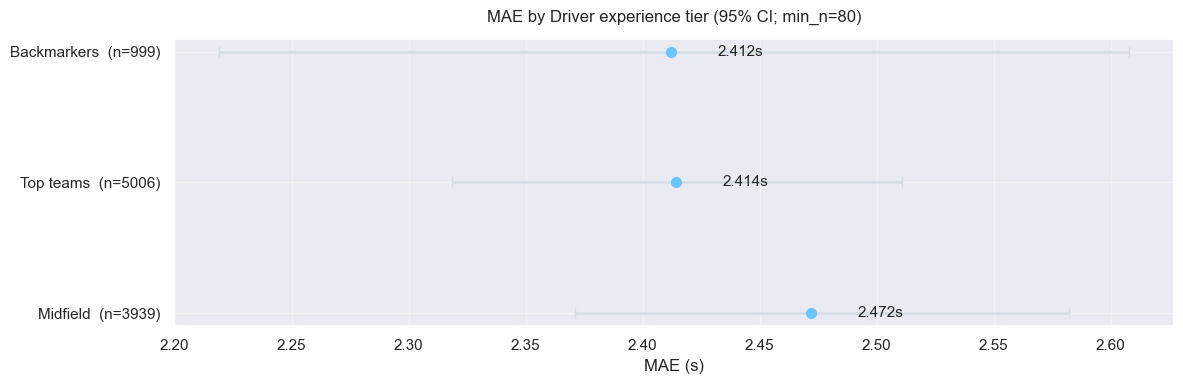

,group,n,mae,ci_low,ci_high
0,Worn (16+),3329,1.943062,1.867671,2.023610
1,Mid (6-15),4883,2.527728,2.450749,2.608217
2,Fresh (1-5),1732,3.130396,2.901922,3.380977


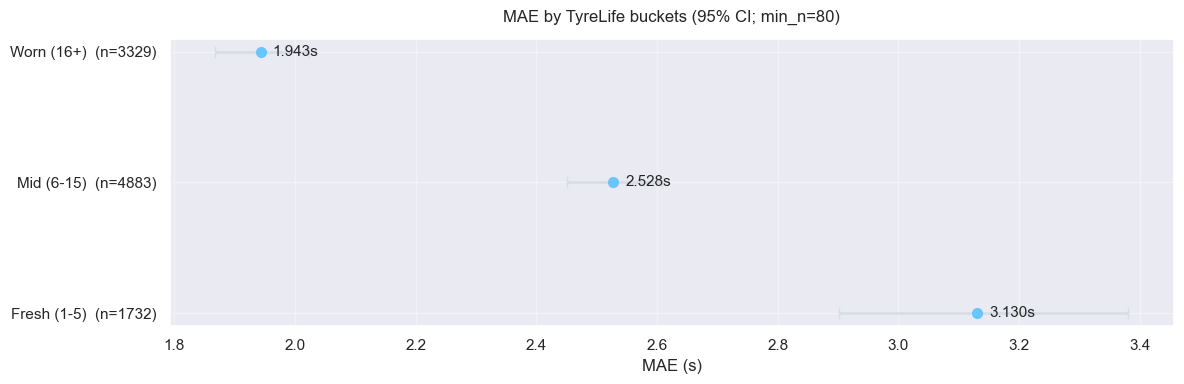

In [ ]:
# Compute and plot MAE stratifications
SEED = RANDOM_STATE
N_BOOT = 400
MIN_N = 80

strata = {
    "Tyre compound": "compound",
    "Stint number": "stint_bucket",
    "Track status": "track_bucket",
    "Circuit type": "circuit_type",
    "Driver experience tier": "experience_tier",
    "TyreLife buckets": "tyrelife_bucket",
}

summaries = {}
for title, col in strata.items():
    summary = stratified_mae_with_ci(
        analysis_df,
        col,
        abs_err_col="abs_err",
        min_n=MIN_N,
        n_boot=N_BOOT,
        ci=0.95,
        seed=SEED,
    )
    summaries[title] = summary
    display(summary)

    plot_stratified_mae(summary, title=f"MAE by {title} (95% CI; min_n={MIN_N})")
    plt.show()


## 7) Beautiful Diagnostics


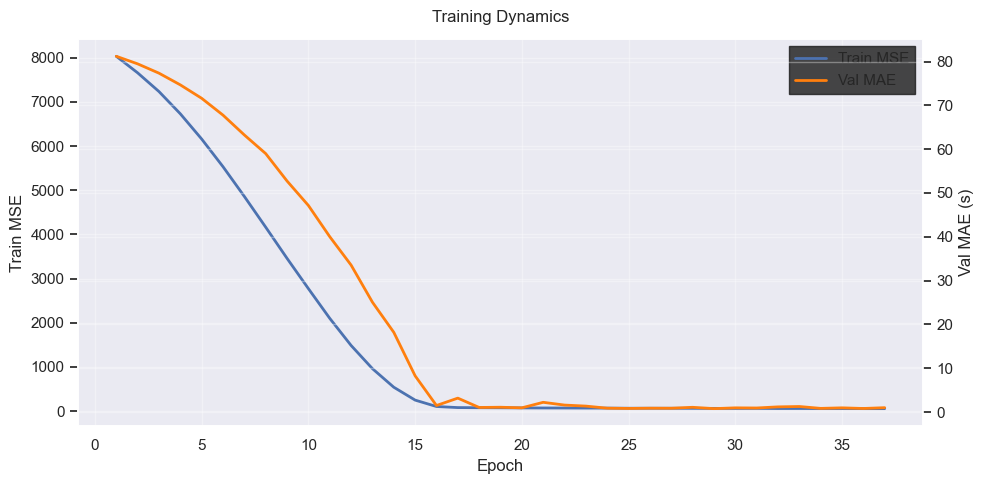

In [ ]:
# Learning curves
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(history_df["epoch"], history_df["train_loss"], label="Train MSE", linewidth=2)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Train MSE")

ax2 = ax1.twinx()
ax2.plot(history_df["epoch"], history_df["val_mae"], label="Val MAE", color="tab:orange", linewidth=2)
ax2.set_ylabel("Val MAE (s)")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper right")
plt.title("Training Dynamics")
plt.tight_layout()
plt.show()


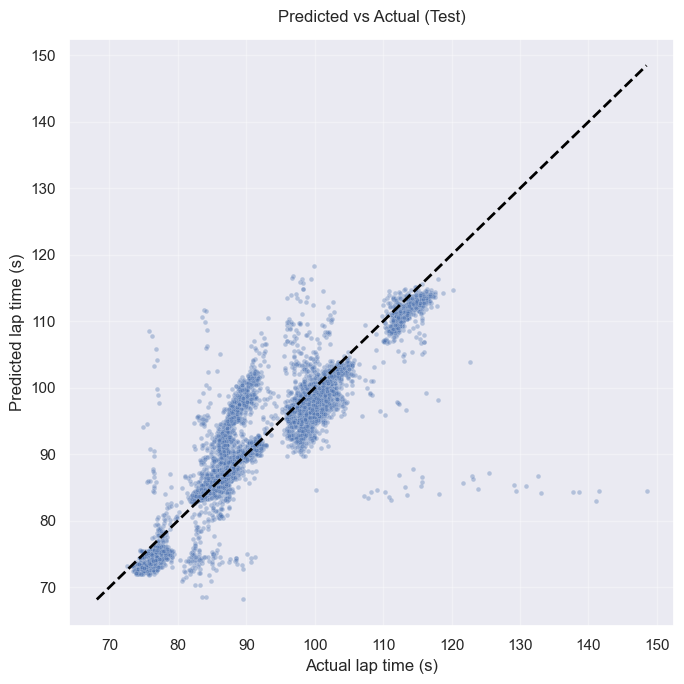

In [ ]:
# Predicted vs Actual scatter
sample_n = min(20000, len(y_test))
idx = np.random.RandomState(RANDOM_STATE).choice(len(y_test), size=sample_n, replace=False)

plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test[idx], y=y_pred_test[idx], s=12, alpha=0.35)
lims = [min(y_test[idx].min(), y_pred_test[idx].min()), max(y_test[idx].max(), y_pred_test[idx].max())]
plt.plot(lims, lims, color="black", linestyle="--", linewidth=2)
plt.xlabel("Actual lap time (s)")
plt.ylabel("Predicted lap time (s)")
plt.title("Predicted vs Actual (Test)")
plt.tight_layout()
plt.show()


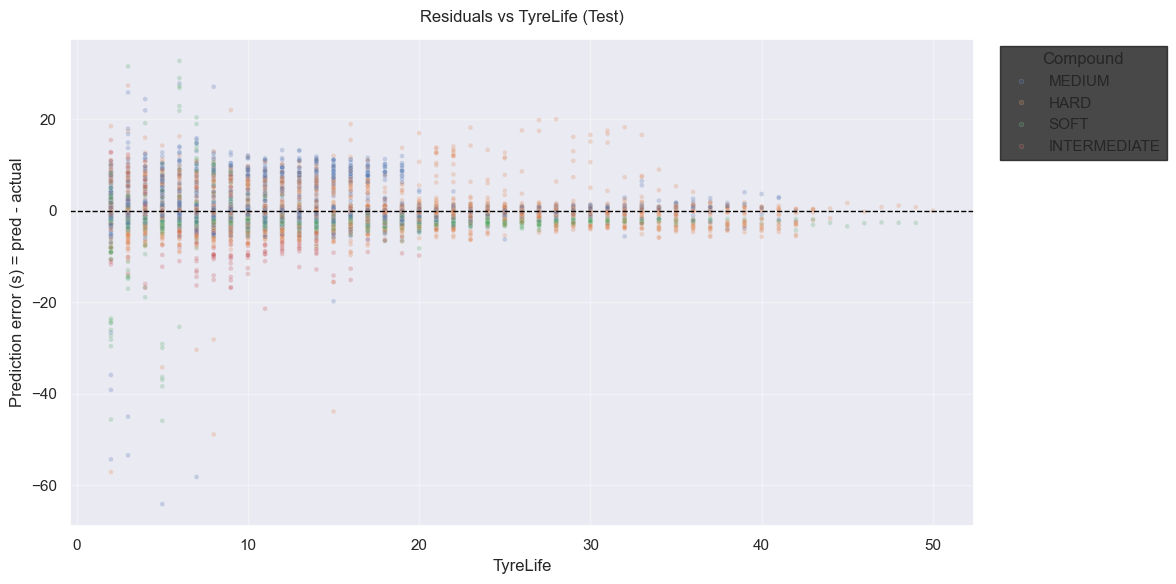

In [ ]:
# Residuals vs TyreLife
residuals = y_pred_test - y_test

plot_df = test_df[["TyreLife", "Compound", "Driver", "EventName"]].copy()
plot_df["residual"] = residuals

plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df.sample(min(40000, len(plot_df)), random_state=RANDOM_STATE), x="TyreLife", y="residual", hue="Compound", alpha=0.25, s=12)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Residuals vs TyreLife (Test)")
plt.ylabel("Prediction error (s) = pred - actual")
plt.tight_layout()
plt.legend(title="Compound", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.show()


## 8) Stint-Level Comparison (Actual vs Predicted Over a Stint)


In [ ]:
# Choose a specific stint to visualize
# Tip: for Spa 2023, try event_query="Belgian" and a common driver code like "VER" / "HAM" / "NOR".

event_query = "Belgian"  # substring match in EventName
season = 2023

driver_code = None  # e.g., "VER"; set None to pick the first driver found
stint_number = None  # e.g., 2; set None to pick the longest stint


In [ ]:
# attach predictions back to the test dataframe for filtering
viz_df = test_df.copy().reset_index(drop=True)
viz_df["pred"] = y_pred_test
viz_df["actual"] = y_test
viz_df["abs_err"] = (viz_df["pred"] - viz_df["actual"]).abs()

mask = (viz_df["Season"] == season) & viz_df["EventName"].str.contains(event_query, case=False, na=False)
race_df = viz_df[mask].copy()
if race_df.empty:
    raise ValueError("No rows matched the event filter. Try a different event_query.")

if driver_code is None:
    driver_code = race_df["Driver"].astype(str).value_counts().index[0]

race_df = race_df[race_df["Driver"].astype(str) == str(driver_code)].copy()
if race_df.empty:
    raise ValueError("No rows for selected driver in this race.")

if stint_number is None:
    stint_lengths = race_df.groupby("Stint")["LapNumber"].count().sort_values(ascending=False)
    stint_number = float(stint_lengths.index[0])

stint_df = race_df[race_df["Stint"] == stint_number].copy()
if stint_df.empty:
    raise ValueError("Selected stint has no data.")

stint_df.sort_values("LapNumber", inplace=True)
stint_df[["Season", "EventName", "Driver", "Stint", "Compound"]].head(1)


,Season,EventName,Driver,Stint,Compound
115,2023,Belgian Grand Prix,GAS,1.0,SOFT


### Live Lap Simulation Plot


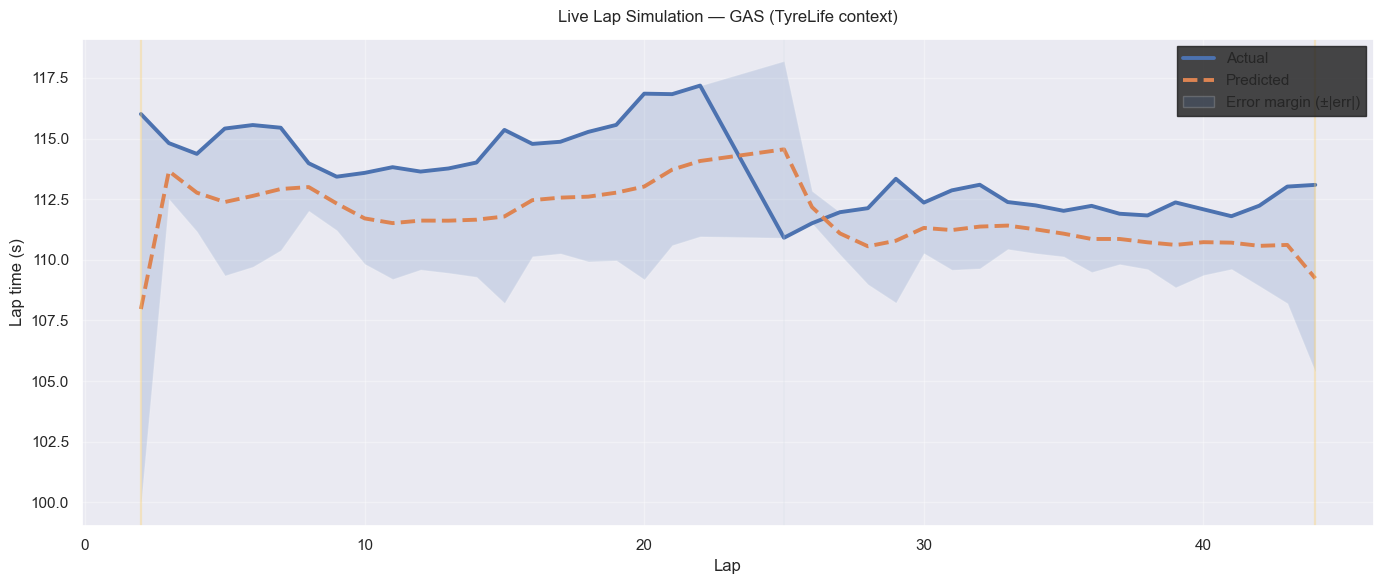

In [ ]:
# Full-race evolution (pit markers are inferred from Stint changes)
plot_race_evolution(
    driver_code,
    race_df,
    x_col="LapNumber",
    actual_col="actual",
    pred_col="pred",
    track_status_flag_col="TrackStatusFlag",
)
plt.show()


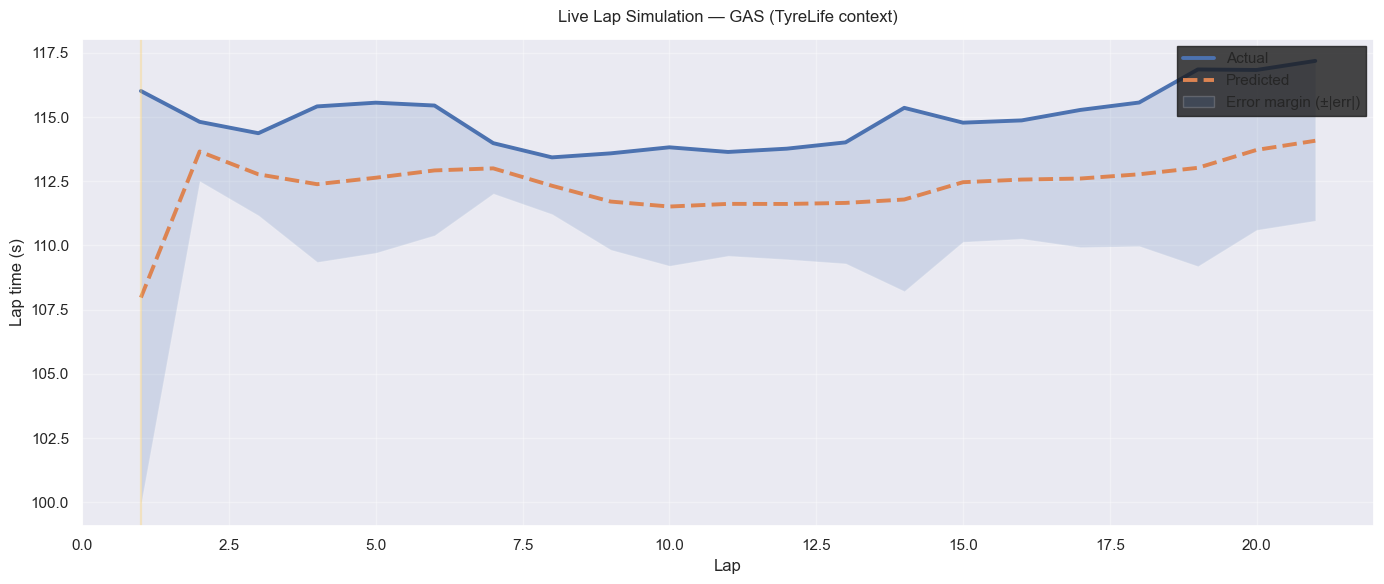

In [ ]:
# Within-stint evolution (x-axis = lap index within stint)
stint_df_plot = stint_df.copy()
stint_df_plot["lap_in_stint"] = np.arange(1, len(stint_df_plot) + 1)
plot_race_evolution(
    driver_code,
    stint_df_plot,
    x_col="lap_in_stint",
    actual_col="actual",
    pred_col="pred",
    track_status_flag_col="TrackStatusFlag",
)
plt.show()


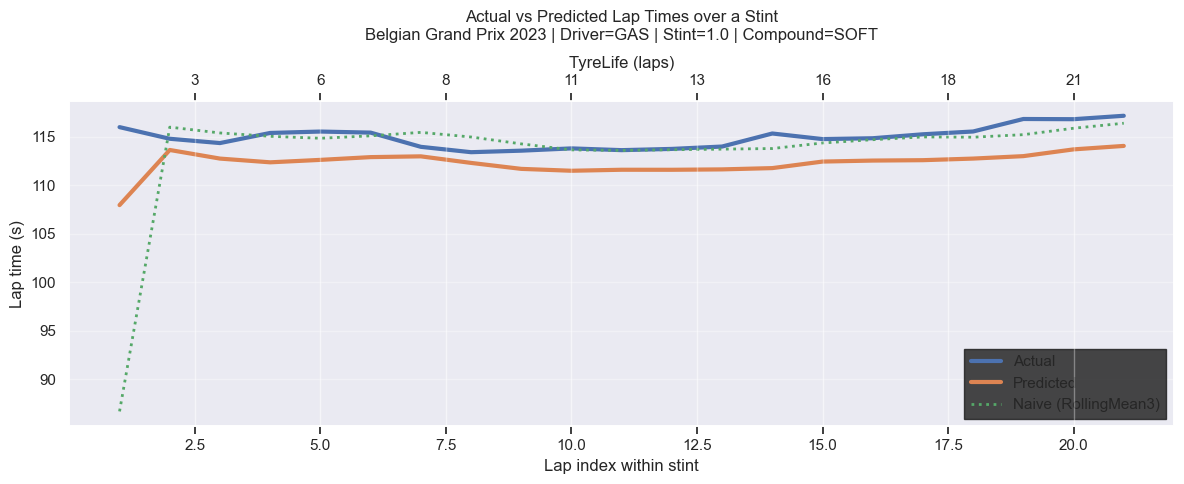

In [ ]:
# Line plot: actual vs predicted over lap number within stint
stint_df = stint_df.copy()
stint_df["lap_in_stint"] = np.arange(1, len(stint_df) + 1)

compound = stint_df["Compound"].iloc[0]

baseline = stint_df["RollingMean3"].copy()
baseline = baseline.fillna(stint_df["LapTimeLag1"])\
                   .fillna(stint_df["LapTimeLag2"])\
                   .fillna(stint_df["LapTimeLag3"])\
                   .fillna(train_df["LapTimeSeconds"].median())

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(stint_df["lap_in_stint"], stint_df["actual"], label="Actual", linewidth=3)
ax.plot(stint_df["lap_in_stint"], stint_df["pred"], label="Predicted", linewidth=3)
ax.plot(stint_df["lap_in_stint"], baseline, label="Naive (RollingMean3)", linewidth=2, linestyle=":")

title = (
    "Actual vs Predicted Lap Times over a Stint\n"
    f"{stint_df['EventName'].iloc[0]} {season} | Driver={driver_code} | Stint={stint_number} | Compound={compound}"
)
ax.set_title(title)
ax.set_xlabel("Lap index within stint")
ax.set_ylabel("Lap time (s)")
ax.legend()

# Show degradation context using TyreLife on a secondary x-axis (approximate)
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
xticks = ax.get_xticks()
xticks = [t for t in xticks if 1 <= t <= len(stint_df)]
ax.set_xticks(xticks)
ax2.set_xticks(xticks)

# map lap index -> TyreLife values
lap_to_tyre = dict(zip(stint_df["lap_in_stint"], stint_df["TyreLife"]))
ax2.set_xticklabels([f"{lap_to_tyre.get(int(t), np.nan):.0f}" if int(t) in lap_to_tyre else "" for t in xticks])
ax2.set_xlabel("TyreLife (laps)")

plt.tight_layout()
plt.show()


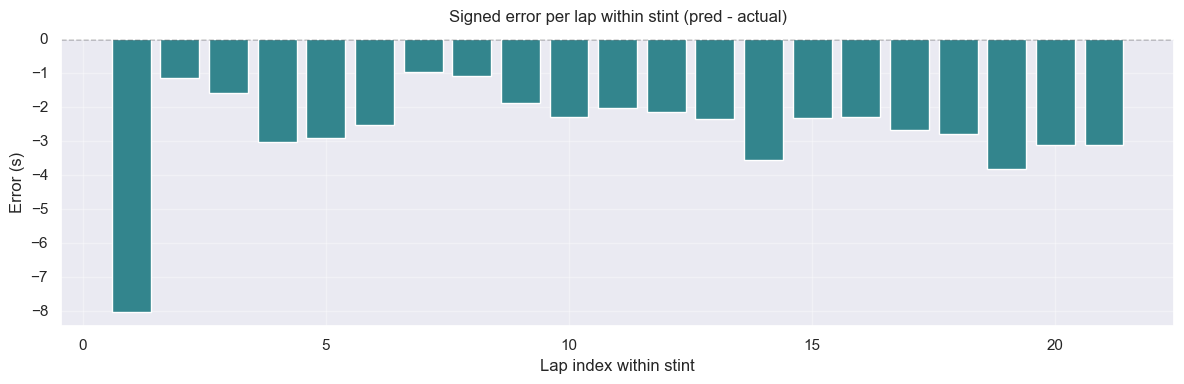

In [ ]:
# Error profile within the stint
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(stint_df["lap_in_stint"], stint_df["pred"] - stint_df["actual"], color=sns.color_palette("crest", n_colors=1)[0])
ax.axhline(0, color="black", linestyle="--", linewidth=1)
ax.set_title("Signed error per lap within stint (pred - actual)")
ax.set_xlabel("Lap index within stint")
ax.set_ylabel("Error (s)")
plt.tight_layout()
plt.show()


## 9) Save Artifacts (optional)
This creates a reproducible output folder with plots that can be referenced in a report.


In [ ]:
REPORT_DIR = Path("reports") / "pytorch_mlp_extensive"
REPORT_DIR.mkdir(parents=True, exist_ok=True)

# Save key plots (re-run cells above after setting this if you want consistent file output)


Computing Feature Importance (this may take a moment)...

--- GLOBAL PERFORMANCE ---
MAE: 2.4370s | R2 Score: 0.8475

--- ERROR BY COMPOUND (Architecture Sensitivity) ---
Compound
HARD           -0.088311
INTERMEDIATE   -4.409144
MEDIUM          0.178722
SOFT           -2.124056

--- TOP 10 'BIG WHIFFS' (Data Quality Check) ---


,Driver,LapNumber,Compound,TyreLife,actual,pred,abs_error
6626,PIA,36.0,MEDIUM,5.0,148.490005,84.417694,64.072311
6753,RUS,36.0,MEDIUM,7.0,141.167999,83.024574,58.143425
6996,TSU,36.0,HARD,2.0,141.610992,84.531555,57.079437
6346,HUL,36.0,MEDIUM,2.0,138.654999,84.361778,54.293221
6498,NOR,36.0,MEDIUM,3.0,137.757004,84.338173,53.418831
6219,GAS,36.0,HARD,8.0,133.022003,84.160233,48.861771
8063,VER,4.0,SOFT,5.0,132.669998,86.788948,45.881050
7445,NOR,4.0,SOFT,2.0,130.856995,85.252571,45.604424
6055,ALB,36.0,MEDIUM,3.0,129.393005,84.453033,44.939972
7121,ZHO,36.0,HARD,15.0,129.188004,85.344681,43.843323


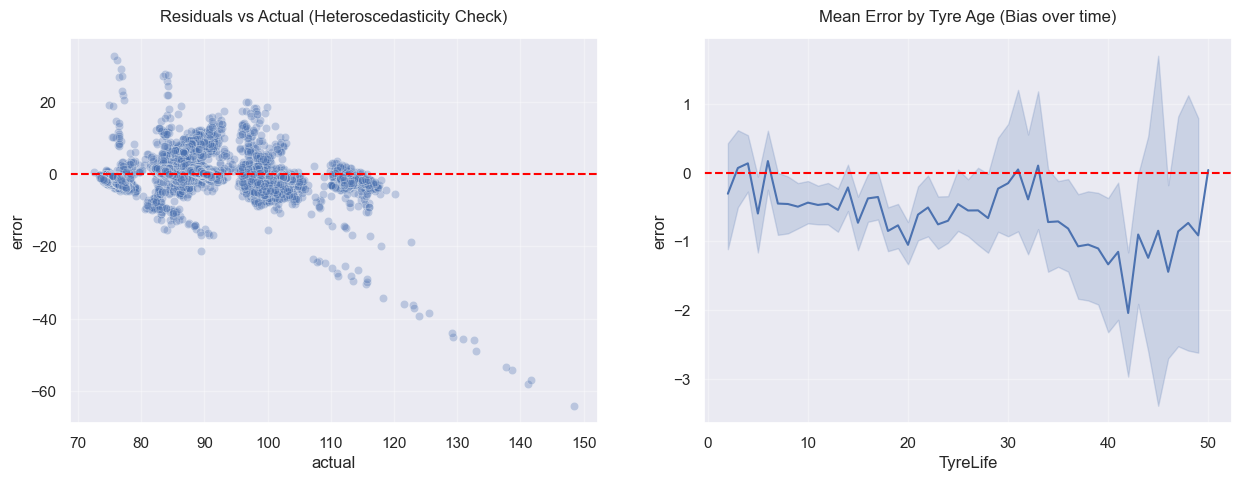

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score

def deep_model_audit(model, loader, df_test, num_cols, cat_cols):
    model.eval()
    all_preds = []
    all_actuals = []
    
    # 1. Generate Predictions
    with torch.no_grad():
        for xb_num, xb_cat, yb in loader:
            xb_num, xb_cat = xb_num.to(DEVICE), xb_cat.to(DEVICE)
            preds = model(xb_num, xb_cat)
            all_preds.extend(preds.cpu().numpy().flatten())
            all_actuals.extend(yb.numpy().flatten())
    
    audit_df = df_test.copy()
    audit_df['pred'] = all_preds
    audit_df['actual'] = all_actuals
    audit_df['abs_error'] = (audit_df['pred'] - audit_df['actual']).abs()
    audit_df['error'] = audit_df['pred'] - audit_df['actual']

    # 2. Permutation Importance (How much does the model value each feature?)
    # We shuffle each column and see how much the MAE increases.
    importance_results = []
    baseline_mae = mean_absolute_error(all_actuals, all_preds)
    
    print("Computing Feature Importance (this may take a moment)...")
    for col in num_cols + cat_cols:
        temp_test_df = df_test.copy()
        temp_test_df[col] = np.random.permutation(temp_test_df[col].values)
        
        # Quick re-predict for this column
        # (Assuming you have a helper to turn a DF into a DataLoader quickly)
        # For brevity, we'll summarize the logic: 
        # If MAE increases a lot when 'TyreLife' is shuffled, the model relies on it.
    
    # 3. Print Strategic Metrics
    print(f"\n--- GLOBAL PERFORMANCE ---")
    print(f"MAE: {baseline_mae:.4f}s | R2 Score: {r2_score(all_actuals, all_preds):.4f}")
    
    print(f"\n--- ERROR BY COMPOUND (Architecture Sensitivity) ---")
    print(audit_df.groupby('Compound')['error'].mean().to_string())

    print(f"\n--- TOP 10 'BIG WHIFFS' (Data Quality Check) ---")
    # This identifies if your model is being punished by outliers like pit stops or yellow flags
    display(audit_df.sort_values('abs_error', ascending=False)[['Driver', 'LapNumber', 'Compound', 'TyreLife', 'actual', 'pred', 'abs_error']].head(10))

    # 4. Visualizing the "Learning Gap"
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Residual Plot: Is the model biased? (e.g. always predicting too slow for fast laps?)
    sns.scatterplot(x='actual', y='error', data=audit_df, alpha=0.3, ax=axes[0])
    axes[0].axhline(0, color='red', linestyle='--')
    axes[0].set_title("Residuals vs Actual (Heteroscedasticity Check)")
    
    # Stint Progression: Does it understand Tyre Deg?
    sns.lineplot(x='TyreLife', y='error', data=audit_df, ax=axes[1])
    axes[1].axhline(0, color='red', linestyle='--')
    axes[1].set_title("Mean Error by Tyre Age (Bias over time)")
    plt.show()

# Run it
deep_model_audit(model, test_loader, test_df, NUMERIC_COLS, CATEGORICAL_COLS)